## Drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.models import Model,Sequential
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, Reshape
from keras.layers import Bidirectional, LSTM
from keras.layers import Lambda, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
from tensorflow import keras

## Load data

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/handwriting.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/validation_v2/validation/VALIDATION_5003.jpg  
  inflating: /content/validation_v2/validation/VALIDATION_5004.jpg  
  inflating: /content/validation_v2/validation/VALIDATION_5005.jpg  
  inflating: /content/validation_v2/validation/VALIDATION_5006.jpg  
  inflating: /content/validation_v2/validation/VALIDATION_5007.jpg  
  inflating: /content/validation_v2/validation/VALIDATION_5008.jpg  
  inflating: /content/validation_v2/validation/VALIDATION_5009.jpg  
  inflating: /content/validation_v2/validation/VALIDATION_5010.jpg  
  inflating: /content/validation_v2/validation/VALIDATION_5011.jpg  
  inflating: /content/validation_v2/validation/VALIDATION_5012.jpg  
  inflating: /content/validation_v2/validation/VALIDATION_5013.jpg  
  inflating: /content/validation_v2/validation/VALIDATION_5014.jpg  
  inflating: /content/validation_v2/validation/VALIDATION_5015.jpg  
  inflating: /content/validation_v2/validation/VALID

In [ ]:
train_dir = os.path.join(os.getcwd(), 'train_v2/train/')
validation_dir = os.path.join(os.getcwd(), 'validation_v2/validation/')

In [ ]:
train = pd.read_csv('/content/written_name_train_v2.csv')
valid = pd.read_csv('/content/written_name_validation_v2.csv')

## Cleaning and preprocessing

In [ ]:
total_train=len(train_dir)
total_val=len(validation_dir)

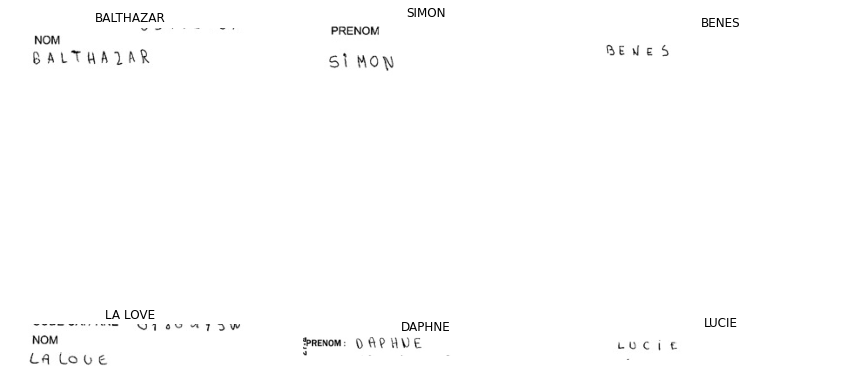

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = train_dir+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')


In [ ]:
print("NaNs in train : ", train['IDENTITY'].isnull().sum())
print("NaNs in validation : ", valid['IDENTITY'].isnull().sum())

NaNs in train :  565
NaNs in validation :  78


In [ ]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

In [ ]:
train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [ ]:
valid.head()

,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP


In [ ]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [ ]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [ ]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [ ]:
print("Total train :",len(train))
print("Total Valid :",len(valid))

Total train : 330294
Total Valid : 41280


In [ ]:
train_size = 25000
valid_size= 7500

In [ ]:
def preprocess(img):
    (h, w) = img.shape    
    final_img = np.ones([64, 256])*255 
    
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [ ]:
train_x = []

for i in range(train_size):
    img_dir = train_dir+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [ ]:
valid_x = []

for i in range(valid_size):
    img_dir = validation_dir+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [ ]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

## CTC 

In [ ]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 34
num_of_characters = len(alphabets) + 1 
num_of_timestamps = 64 


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY']) 

In [ ]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY']) 

In [ ]:
print('original : ',train.loc[1, 'IDENTITY'] )
print('train_y : ',train_y[1])
print('train_label_len : ',train_label_len[1])

original :  SIMON
train_y :  [18.  8. 12. 14. 13. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
train_label_len :  [5.]


## Model

In [ ]:
'''model = keras.Sequential()

model.add(Conv2D(64, (3, 3), activation = 'relu',input_shape = (256,64,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3, 3),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(1,2))
model.add(Dropout(0.3))

model.add(tf.keras.layers.Reshape((90,256,1)))

model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Flatten())

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(64,activation='relu', kernel_initializer='he_normal'))
model.add(layers.Dense(num_of_characters, kernel_initializer='he_normal',activation='relu'))'''

"model = keras.Sequential()\n\nmodel.add(Conv2D(64, (3, 3), activation = 'relu',input_shape = (256,64,1)))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(2,2))\n\nmodel.add(Conv2D(64, (3, 3),activation = 'relu'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(2,2))\nmodel.add(Dropout(0.3))\n\nmodel.add(Conv2D(128, (3, 3), activation = 'relu'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(1,2))\nmodel.add(Dropout(0.3))\n\nmodel.add(tf.keras.layers.Reshape((90,256,1)))\n\nmodel.add(Dense(64, activation='relu', kernel_initializer='he_normal'))\nmodel.add(Flatten())\n\nmodel.add(\n    layers.Bidirectional(layers.LSTM(64, return_sequences=True))\n)\nmodel.add(layers.Bidirectional(layers.LSTM(32)))\nmodel.add(\n    layers.Bidirectional(layers.LSTM(64, return_sequences=True))\n)\nmodel.add(layers.Bidirectional(layers.LSTM(32)))\nmodel.add(layers.Dense(64,activation='relu', kernel_initializer='he_normal'))\nmodel.add(layers.Dense(num_of_characters, kernel_initia

In [ ]:
input_data = Input(shape=(256, 64, 1), name='input')

In [ ]:
model = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(input_data)  
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

In [ ]:
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Dropout(0.3)(model)

In [ ]:
model = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = MaxPooling2D(pool_size=(1, 2))(model)
model = Dropout(0.3)(model)

In [ ]:
model = Reshape(target_shape=((64, 1024)))(model)
model = Dense(64, activation='relu', kernel_initializer='he_normal')(model)

In [ ]:
model = Bidirectional(LSTM(256, return_sequences=True))(model)
model = Bidirectional(LSTM(256, return_sequences=True))(model)

In [ ]:
model = Dense(num_of_characters, kernel_initializer='he_normal')(model)
y_pred = Activation('softmax')(model)

In [ ]:
model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 32, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)       256   

## Training

In [ ]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
labels = Input(shape=[max_str_len], dtype='float32')
input_length = Input(shape=[1], dtype='int64')
label_length = Input(shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=8, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

In [ ]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001),metrics='accuracy')


In [ ]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001),metrics='accuracy')

history = model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=100, batch_size=32,callbacks=[early_stopping])

Epoch 1/100
782/782 [==============================] - 111s 70ms/step - loss: 29.7532 - accuracy: 0.0000e+00 - val_loss: 19.9062 - val_accuracy: 0.0000e+00
Epoch 2/100
782/782 [==============================] - 52s 66ms/step - loss: 19.7496 - accuracy: 0.0000e+00 - val_loss: 18.8549 - val_accuracy: 0.0000e+00
Epoch 3/100
782/782 [==============================] - 52s 66ms/step - loss: 18.3573 - accuracy: 0.0000e+00 - val_loss: 17.1115 - val_accuracy: 0.0000e+00
Epoch 4/100
782/782 [==============================] - 51s 66ms/step - loss: 15.9407 - accuracy: 0.0000e+00 - val_loss: 14.5212 - val_accuracy: 0.0000e+00
Epoch 5/100
782/782 [==============================] - 51s 66ms/step - loss: 11.7309 - accuracy: 0.0000e+00 - val_loss: 9.2955 - val_accuracy: 1.3333e-04
Epoch 6/100
782/782 [==============================] - 52s 66ms/step - loss: 7.5996 - accuracy: 0.0023 - val_loss: 9.3317 - val_accuracy: 0.0000e+00
Epoch 7/100
782/782 [==============================] - 52s 66ms/step - loss:

In [ ]:
model_final.save("Model.h5")

**Validation**

In [ ]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [ ]:
for i in range(0,10):
  print("prediced :",prediction[i])
  print("Original :",valid.loc[i, 'IDENTITY'])
  print()

prediced : BILEL
Original : BILEL

prediced : LAUMONIER
Original : LAUMIONIER

prediced : LEA
Original : LEA

prediced : JEAN-ROCH
Original : JEAN-ROCH

prediced : RUPP
Original : RUPP

prediced : PICHON
Original : PICHON

prediced : DANIEL
Original : DANIEL

prediced : JEREMY
Original : JEREMY

prediced : JEAN-MICHEL
Original : JEAN-MICHEL

prediced : JULIEN
Original : JULIEN



In [ ]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print("Correct characters predicted",correct_char*100/total_char)
print("Correct words predicted",correct*100/valid_size)

Correct characters predicted 86.80973460353727
Correct words predicted 72.42666666666666


**Train**

In [ ]:
preds = model.predict(train_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],greedy=True)[0][0])

prediction_train = []
for i in range(train_size):
    prediction_train.append(num_to_label(decoded[i]))

In [ ]:
y_true = train.loc[0:train_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(train_size):
    pr = prediction_train[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print("Correct characters predicted",correct_char*100/total_char)
print("Correct words predicted",correct*100/train_size)

Correct characters predicted 90.30203662125207
Correct words predicted 81.78


## Testing Model

In [ ]:
test = pd.read_csv('/content/written_name_test_v2.csv')
test_dir = os.path.join(os.getcwd(), 'test_v2/test/')
test_size = 2000
test_x = []

In [ ]:
test.head()

,FILENAME,IDENTITY
0,TEST_0001.jpg,KEVIN
1,TEST_0002.jpg,CLOTAIRE
2,TEST_0003.jpg,LENA
3,TEST_0004.jpg,JULES
4,TEST_0005.jpg,CHERPIN


In [ ]:
for i in range(test_size):
    img_dir = test_dir+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    test_x.append(image)

In [ ]:
test_x = np.array(test_x).reshape(-1, 256, 64, 1)

In [ ]:
test_x[30]

array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]])

In [ ]:
preds = model.predict(test_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],greedy=True)[0][0])

prediction_test = []
for i in range(test_size):
    prediction_test.append(num_to_label(decoded[i]))

In [ ]:
for i in range(0,10):
  print("prediced :",prediction_test[i])
  print("Original :",test.loc[i, 'IDENTITY'])
  print()

prediced : KEVIN
Original : KEVIN

prediced : LCCOTY
Original : CLOTAIRE

prediced : LENA
Original : LENA

prediced : JULES
Original : JULES

prediced : CHERPIN
Original : CHERPIN

prediced : MARTIN
Original : MARTIN

prediced : VALENTINE
Original : VALENTINE

prediced : LORAS
Original : LORAS

prediced : THIBAULT
Original : THIBAULT

prediced : AJAY
Original : AZABI



In [ ]:
y_true = test.loc[0:test_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(test_size):
    pr = prediction_test[i]
    tr = str(y_true[i])
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print("Correct characters predicted : ",correct_char*100/total_char)
print("Correct words predicted : ",correct*100/test_size)

Correct characters predicted :  85.97003457548982
Correct words predicted :  71.65


## Visualization

In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


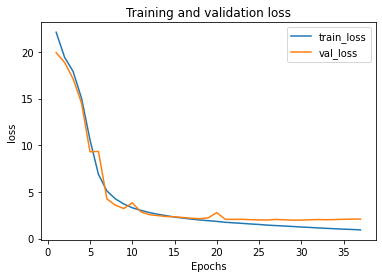

In [ ]:
plot_metric(history,"loss")

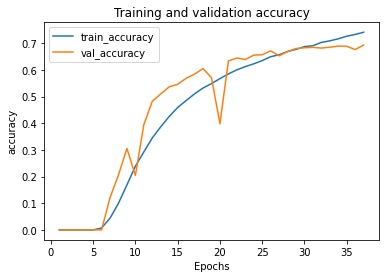

In [ ]:
plot_metric(history,"accuracy")

## prediction

In [ ]:
img_dir = test_dir+test.loc[4001, 'FILENAME']
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
image = preprocess(image)
image = image/255.

In [ ]:
image = np.array(image).reshape(-1, 256, 64, 1)

In [ ]:
preds = model.predict(image)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],greedy=True)[0][0])

predicted = num_to_label(decoded[0])

(-0.5, 323.5, 43.5, -0.5)

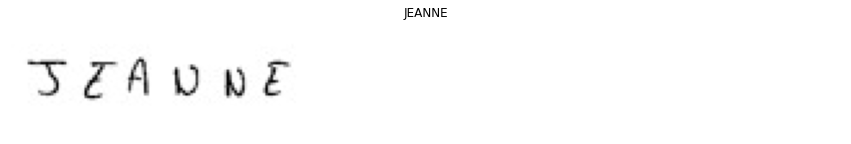

In [ ]:
plt.figure(figsize=(15, 10))
img_dir = test_dir+test.loc[4001, 'FILENAME']
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap = 'gray')
plt.title(test.loc[4001, 'IDENTITY'], fontsize=12)
plt.axis('off')

In [ ]:
print("prediced :",predicted)
print("Original :",test.loc[4001, 'IDENTITY'])

prediced : JEAUNE
Original : JEANNE


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving TEST_0009.jpg to TEST_0009 (1).jpg


In [ ]:
image = cv2.imread('/content/TEST_0009.jpg', cv2.IMREAD_GRAYSCALE)
image = preprocess(image)
image = image/255.

In [ ]:
image = np.array(image).reshape(-1, 256, 64, 1)

In [ ]:
preds = model.predict(image)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],greedy=True)[0][0])

predicted = num_to_label(decoded[0])

(-0.5, 387.5, 26.5, -0.5)

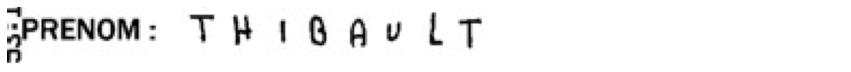

In [ ]:
plt.figure(figsize=(15, 10))
img_dir = '/content/TEST_0009.jpg'
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap = 'gray')
plt.axis('off')

In [ ]:
print("prediced :",predicted)

prediced : THIBAULT
